# Charges Prediction (Regression Analysis)

Here we will try to create a model that will predict medical insurance costs.  The dataset we will be using comes from https://www.kaggle.com/datasets/mirichoi0218/insurance.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data Exploration and Preprocessing

In [3]:
data = pd.read_csv("insurance.csv")

In [4]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Here we can see that we have both numerical and categorical variables.  Our goal will be to predict "charges".  First we will test the correlation beween the numerical variables.  To view this in a visually appealing way, we will use a heat map.

<AxesSubplot:>

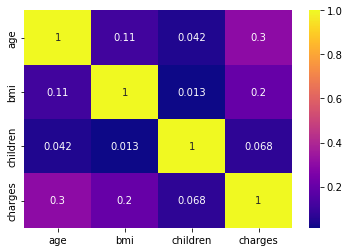

In [6]:
sns.heatmap(data.corr(),annot=True,cmap="plasma")

As we can see, all of the correlations are well below 0.8, so we do not have any multicollinearity.  If we did have multicollinearity we would address this using the variance inflation factor as a means of detection.  Next we will look at the distribution of our numerical features.

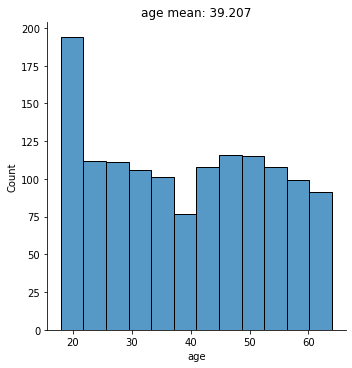

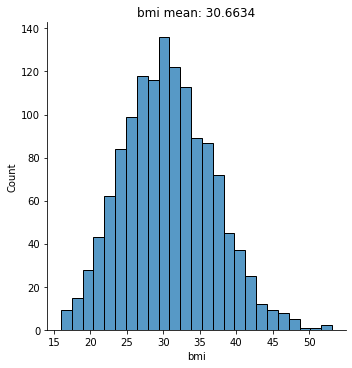

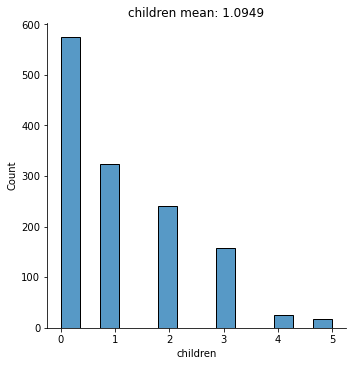

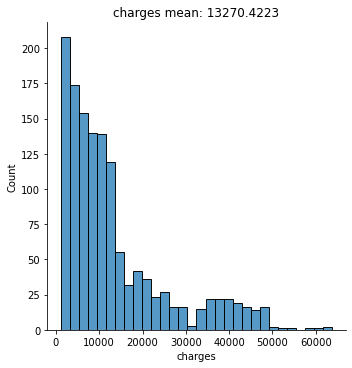

In [7]:
for i in data.columns:
    if data[i].dtype!=object:
        sns.displot(data[i])
        plt.title(f"{i} mean: {round(data[i].mean(),4)}")
        plt.show()

In [8]:
def boxplot(data, data_columns):
    for i in data_columns:
        if data[i].dtype!=object:
            sns.boxplot(data[i])
            plt.title(i)
            plt.show()

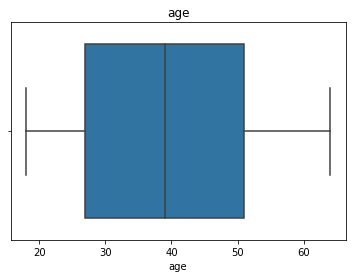

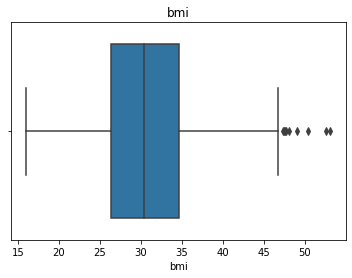

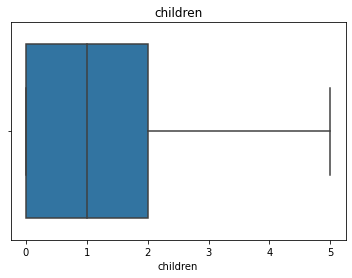

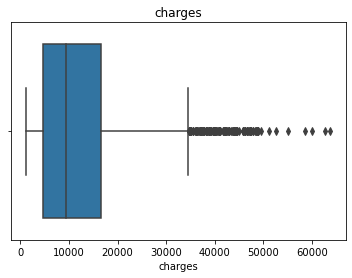

In [9]:
boxplot(data, data.columns)

As we can see, the BMI feature has a few outliers on the higher end.  We will deal with this by removing those that are 3 standard deviations above the mean.

In [10]:
bmi_mean=data.bmi.mean()
bmi_std=data.bmi.std()
bmi_indexes=[]

for index,value in enumerate(data.bmi):
    z=(value-bmi_mean)/bmi_std
    if abs(z)>3:
        bmi_indexes.append(index)

In [11]:
bmi_indexes

[116, 847, 1047, 1317]

In [12]:
data_clean=data.drop(bmi_indexes,axis=0)

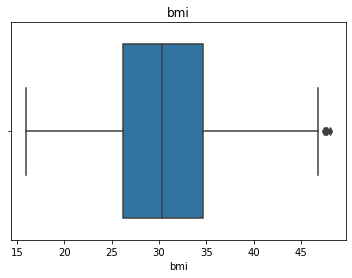

In [13]:
boxplot(data_clean, ["bmi"])

There are still some outliers for the BMI, so we will remove those that are above the upper limit (those above Q3+1.5 IQR).

In [14]:
upper_limit=data_clean.bmi.quantile(0.75)+(data_clean.bmi.quantile(0.75)-data_clean.bmi.quantile(0.25))*1.5

In [15]:
upper_limit

47.13125

In this case the upper limit is a BMI of 47.13, so we will remove those that are greater.

In [16]:
indexes_upper=data_clean.loc[data_clean.bmi>upper_limit].index

In [17]:
indexes_upper

Int64Index([286, 401, 543, 860, 1088], dtype='int64')

In [18]:
data_clean=data_clean.drop(indexes_upper, axis=0)

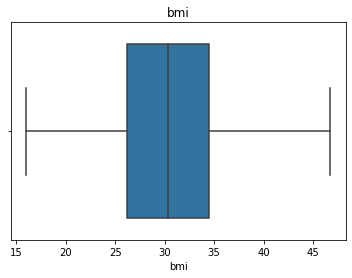

In [19]:
boxplot(data_clean, ["bmi"])

Now that the numerical features are cleaned, we can take a look at the distribution of the categorical features.

In [20]:
cat=["sex", "smoker", "region"]

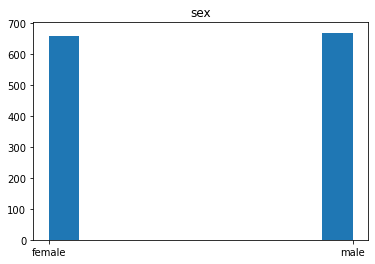

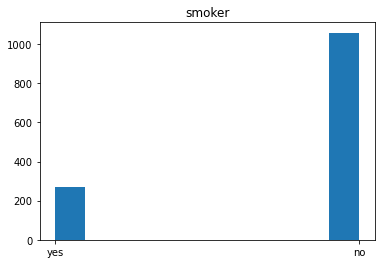

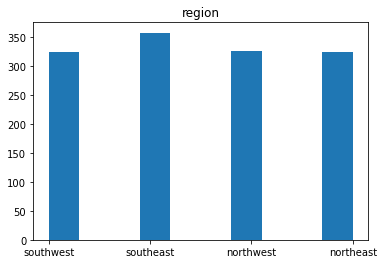

In [21]:
for i in cat:
    data_clean[i].hist(grid=False)
    plt.title(i)
    plt.show()

Prior to creating our regression model, the inputs need to be in numerical format.  In our case, we can use pd.get_dummies() to encode our categorical variables.

In [22]:
data_encoded=pd.get_dummies(data_clean)

In [23]:
data_encoded.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


Now that our data is encoded, we can split our data into X and y dataframes to be used as inputs into our model.

In [24]:
y=data_encoded.charges

In [25]:
X=data_encoded.drop("charges", axis=1)

## Model Selection

Here we will be testing the models.  The two main models we will use are linear regression and random forest regression.

The function regression_model() takes in our X and y data as input, as well as our model (estimator).  It also takes in a boolean for scale, which allows us to scale our data using standard scaler.  In our case we will be scaling our data because our numerical data like age and bmi  have different units of measurement.  Once this function is ran, it will return our model, X_train and y_train data.   We will evaluate the success of the model using the mean absolute percentage error and r2 score.  Our test size will be 20% of the total data set.

In [26]:
def regression_model(X, y, scale, estimator):    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    if scale == True:
        ss=StandardScaler()
        ss.fit(X_train)
        X_train=ss.transform(X_train)
        X_test=ss.transform(X_test)
    model=estimator
    model.fit(X_train,y_train)
    preds_train=model.predict(X_train)
    preds_test=model.predict(X_test)
    mean_abs_pct_error_train=round((mean_absolute_percentage_error(y_train,preds_train)),4)
    mean_abs_pct_error_test=round((mean_absolute_percentage_error(y_test,preds_test)), 4)
    r2_train=round(r2_score(y_train,preds_train),4)
    r2_test=round(r2_score(y_test,preds_test),4)
    print(f"The train mean abs % error is {mean_abs_pct_error_train} and r2 is {r2_train}")
    print(f"The test mean abs % error is {mean_abs_pct_error_test} and r2 is {r2_test}")
    return model, X_train, y_train

In [27]:
estimator=LinearRegression()
model, X_train, y_train = regression_model(X, y, True, estimator)

The train mean abs % error is 0.4122 and r2 is 0.7507
The test mean abs % error is 0.4066 and r2 is 0.744


The linear regression model has a decent r2, score and it doesn't seem to be overfitting or underfitting.  However, the mean absolute percentage error is high.  Let's see if we can make some adjustments by trying lasso, ridge, and elastic net regularizations.

In [28]:
estimator=Ridge(alpha=10)
model, X_train, y_train = regression_model(X, y, True, estimator)

The train mean abs % error is 0.4135 and r2 is 0.7506
The test mean abs % error is 0.4084 and r2 is 0.744


In [29]:
estimator=Lasso(alpha=10)
model, X_train, y_train = regression_model(X, y, True, estimator)

The train mean abs % error is 0.4122 and r2 is 0.7507
The test mean abs % error is 0.407 and r2 is 0.7437


In [30]:
estimator=ElasticNet(alpha=10)
model, X_train, y_train = regression_model(X, y, True, estimator)

The train mean abs % error is 1.2168 and r2 is 0.3484
The test mean abs % error is 1.154 and r2 is 0.3483


I have alpha=10 here, but we can of course try different values of alpha.  However, when I tried to differnt values of alphas, the model was not significantly improving.  Now let's try a random forest regressor.

In [31]:
estimator=RandomForestRegressor()
model, X_train, y_train = regression_model(X, y, True, estimator)

The train mean abs % error is 0.1247 and r2 is 0.9762
The test mean abs % error is 0.3506 and r2 is 0.8246


The random forest regressor is giving us less error and a higher r2 score, but it looks like our it is overfitting.  Let's try to tune some paramaters to make this better.

## Hyperparameter Tuning

In [32]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

As we can see, there are plenty of different parameters that are within the RandomForestRegressor() function.  I will be adjusting the max_depth, n_estimators, and bootstrap parameters to see if we can improve our model.  I will be using grid search with 3-fold cross validation to optimize these parameters.  The scoring will be measured by r2.

In [33]:
param={"max_depth":[3,4,5],"n_estimators":[10,100,1000],"bootstrap":[True, False]}

In [34]:
gs=GridSearchCV(RandomForestRegressor(),param_grid=param,scoring="r2",cv=3)

In [35]:
gs.fit(X_train,np.array(y_train).ravel())

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False], 'max_depth': [3, 4, 5],
                         'n_estimators': [10, 100, 1000]},
             scoring='r2')

In [36]:
gs.best_score_

0.8540935441407926

In [37]:
gs.best_params_

{'bootstrap': True, 'max_depth': 3, 'n_estimators': 100}

The grid search's best parameters from the ones that I tested are bootstrap=True, max_depth=3, and n_estimators=100.  Let's test them on our model.

In [38]:
estimator=RandomForestRegressor(n_estimators=100,max_depth=3,random_state=1,bootstrap=True)
model, X_train, y_train = regression_model(X, y, True, estimator)

The train mean abs % error is 0.3419 and r2 is 0.864
The test mean abs % error is 0.3417 and r2 is 0.8517


As we can see, hypertuning our random forest regressor model has led to better model performance, with no overfitting.  It has the best r2 scores and lowest error scores out of all the models that don't overfit.  

To get more clarity on our model's performance, we can use cross validation:

In [39]:
cross_validate(estimator,X,y,scoring="r2",cv=3,return_estimator=True,return_train_score=True)

{'fit_time': array([0.16954589, 0.15259552, 0.14361358]),
 'score_time': array([0.00997305, 0.0099721 , 0.00997305]),
 'estimator': [RandomForestRegressor(max_depth=3, random_state=1),
  RandomForestRegressor(max_depth=3, random_state=1),
  RandomForestRegressor(max_depth=3, random_state=1)],
 'test_score': array([0.86291822, 0.84897758, 0.83865694]),
 'train_score': array([0.85938758, 0.86426855, 0.86970492])}

As we can see from the cross validation, our model works well on different data samples as well.

## Visualization

In [40]:
from sklearn.decomposition import PCA

We can also visualize the trend of our data.  Since we have many features, we can us PCA to reduce dimensions.  We will be using 90% of our data as the cutoff for the PCA.

In [41]:
pca=PCA(0.90)
X_pca=pca.fit_transform(X)

In [42]:
X_pca.shape

(1329, 2)

In [43]:
X_df=pd.DataFrame(X_pca)

In [44]:
pca.explained_variance_ratio_

array([0.84063294, 0.14658041])

As we can see, 84.1% of the variance is explained by the first component, and 14.7% of the variance is explained by the second component.  We can plot the charges against each component to visualize our data. 

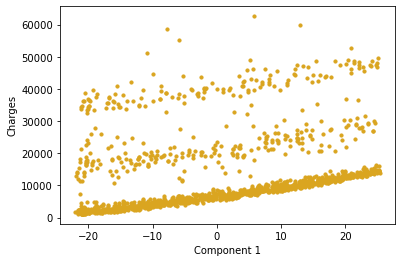

In [45]:
plt.scatter(X_df[0], y, s=10, color='goldenrod')
plt.xlabel('Component 1')
plt.ylabel('Charges')
plt.show()

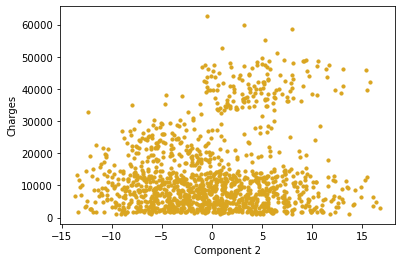

In [46]:
plt.scatter(X_df[1], y, s=10, color='goldenrod')
plt.xlabel('Component 2')
plt.ylabel('Charges')
plt.show()

As we can see based on our graphs, 84.1% of our data is exhibiting a linear trend, whereas 14.7% is not really exhibiting much of a trend.